In [4]:
# -*- coding: utf-8 -*-

import functools
import numpy as np
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt


import pso
import ann
#activationLayer="tanh"
#np.random.seed(6663)
def dim_weights(shape):
    dim = 0
    for i in range(len(shape)-1):
        dim = dim + (shape[i] + 1) * shape[i+1]
    return dim

def weights_to_vector(weights):
    w = np.asarray([])
    for i in range(len(weights)):
        v = weights[i].flatten()
        w = np.append(w, v)
    return w

def vector_to_weights(vector, shape):
    weights = []
    idx = 0
    for i in range(len(shape)-1):
        r = shape[i+1]
        c = shape[i] + 1
        idx_min = idx
        idx_max = idx + r*c
        W = vector[idx_min:idx_max].reshape(r,c)
        weights.append(W)
    return weights



#this is the optimisation for the coords of the particles??
def eval_neural_network(weights, shape, X, y,activationLayer):
    mse = np.asarray([])
    for w in weights:
        weights = vector_to_weights(w, shape)
        nn = ann.MultiLayerPerceptron(shape, weights=weights)
        y_pred = nn.run(X,activationLayer)
        #print("eval network :",y.shape,y_pred.shape,X.shape)
        mse = np.append(mse, sklearn.metrics.mean_squared_error(y, y_pred))
    return mse

def print_best_particle(best_particle):
    print("New best particle found at iteration #{i} with mean squared error: {score}".format(i=best_particle[0], score=best_particle[1]))




#just xy error = 0.22938741634873416
#with sinx sin y error = 0.2325498216710004
#with sin and sq error = 0.21790465807135315

In [5]:

def sine(X):
    return np.sin(X)


#loading Starts here

def sq(X):
    return np.power(X,2)

num_classes = 2
f = open("two_spirals.dat","r")
data = np.loadtxt(f)
X = data[:,0:2]
y = data[:,2]
y = y.astype(int)


def generateData(X,y,ratio,sin=False,square=False):
    if sin and square:
        X = np.hstack((X,np.hstack((sq(X),sine(X)))))
      #  print(X[0])
    elif sin:
        X=np.hstack((X,sine(X)))
    elif square:
        X = np.hstack((X,sq(X)))
    train_test_split = int(ratio*len(y))
    X_train,X_test = X[:train_test_split],X[train_test_split:]
    y_train,y_test = y[:train_test_split],y[train_test_split:]  
    return X,X_train,X_test,y_train,y_test

X,X_train,X_test,y_train,y_test=generateData(X,y,0.5,True,True)


#so x train and y train are basically x and y in this file

X = X_train
y = y_train
print(len(y_train))
print(X_train.shape)

132
(132, 6)


In [6]:

# # Load MNIST digits from sklearn

# num_classes = 10
# mnist = sklearn.datasets.load_digits(num_classes)
# X, X_test, y, y_test = sklearn.model_selection.train_test_split(mnist.data, mnist.target)

num_inputs = X.shape[1]
print("Number of inputs = ",num_inputs)
y_true = np.zeros((len(y), num_classes))

for i in range(len(y)):
    y_true[i, y[i]] = 1
  #  print(y_true[i],y[i])

y_test_true = np.zeros((len(y_test), num_classes))
for i in range(len(y_test)):
    y_test_true[i, y_test[i]] = 1

# print("y test shap e= ", y_test.shape)
# print("y true shape = ",y_true.shape)
# print("y test true shape = ",y_test_true.shape)
# print(X_test.shape)
# print(X_train.shape)

print(y_test_true.shape,y_true.shape)

Number of inputs =  6
(132, 2) (132, 2)


In [14]:
iterations = 5000

def training(shape,activationLayer):
  #  print("input  :",X.shape,y_true.shape)
    cost_func = functools.partial(eval_neural_network, shape=shape, X=X, y=y_true.T,activationLayer=activationLayer)

    swarm = pso.ParticleSwarm(cost_func, num_dimensions=dim_weights(shape), num_particles=27,chi=0.72989 ,phi_p=2.02,phi_g=2.02)
    # Train...
    i = 0
    best_scores = [(i, swarm.best_score)]
    print_best_particle(best_scores[-1])
    
    trainingLoss = []
    testloss = []
    while swarm.best_score>1e-6 and i<iterations:
        swarm._update()
        i = i+1
        
        best_weights = vector_to_weights(swarm.g, shape)
        best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)
        y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)
        testError = sklearn.metrics.mean_squared_error((y_test_true.T),y_test_pred)
        
        #print("index = ",i)
        if i%2500==0 and swarm.best_score < best_scores[-1][1]:
            best_scores.append((i, swarm.best_score))
            print_best_particle(best_scores[-1])
            #training per epoch
            print("Mean absolute error score for index   =",i,(activationLayer,testError))
        trainingLoss.append(swarm.best_score)
        testloss.append(testError)
        
    # Test...
#     print("shape of test pred : ",y_test_pred.shape)
    
#     best_weights = vector_to_weights(swarm.g, shape)
#     best_nn = ann.MultiLayerPerceptron(shape, weights=best_weights)

#     y_test_pred =np.round(best_nn.run(X_test,activationLayer),0)
#     points = np.arange(iterations)
#     plt.plot(points,testloss,color="b",label="Test loss")
#     plt.plot(points,trainingLoss,color="r",label="Train loss")
#     plt.xlabel("Iterations")
#     plt.ylabel("Error")
#     plt.title(activationLayer)
#     plt.legend()
#     plt.show()


    ##this is dumb
    #eval neural network is pritning the mean squared error at each time
    print("best score = ",best_scores[ -1])
  #  print(sklearn.metrics.classification_report(y_test_true, y_test_pred.T))

    print("Mean absolute error score for  =",(activationLayer, sklearn.metrics.mean_squared_error(y_test_true,y_test_pred.T)))
    #print("Accuracy score = ",sklearn.metrics.accuracy_score(y_test_true,y_test_pred.T))
    return testloss


In [15]:
# shape=(num_inputs,4,num_classes)
# activationLayer="relu"
# testLoss = training(shape,activationLayer)
# points = np.arange(iterations)
# plt.plot(points[4:],testLoss[4:])
# plt.show()
# # # training(shape,"sigmoid")

In [16]:
activations = ['sigmoid','tanh','relu','identity']#,'relu','default']
#iterations = 10000

def testRun():
    '''
    I want mse to be y axis
    I want neurons to be x axis
    then I will have 3 plots, tanh, sigmoid and relu?
    '''
    #shape = (num_inputs, 8, num_classes)

    neurons = [4,5,6,7,8]
    arrays = np.zeros(shape=(len(activations),len(neurons),iterations))

    for i in range(len(arrays)):
        activationLayer = activations[i]
        for k in range(len(neurons)):
            shape = (num_inputs,neurons[k],num_classes)
            mse = training(shape,activationLayer)
            arrays[i][k]=mse
            
            print(i,k)
     #   print(i)

    return arrays
arrays = testRun()

New best particle found at iteration #0 with mean squared error: 0.3154287180091389
New best particle found at iteration #2500 with mean squared error: 0.17312326650511073
Mean absolute error score for index   = 2500 ('sigmoid', 0.29545454545454547)
New best particle found at iteration #5000 with mean squared error: 0.17239914022063524
Mean absolute error score for index   = 5000 ('sigmoid', 0.29545454545454547)
best score =  (5000, 0.17239914022063524)
Mean absolute error score for  = ('sigmoid', 0.29545454545454547)
0 0
New best particle found at iteration #0 with mean squared error: 0.36800974137309916
New best particle found at iteration #2500 with mean squared error: 0.14089287161974445
Mean absolute error score for index   = 2500 ('sigmoid', 0.26136363636363635)
New best particle found at iteration #5000 with mean squared error: 0.12314304751452104
Mean absolute error score for index   = 5000 ('sigmoid', 0.24621212121212122)
best score =  (5000, 0.12314304751452104)
Mean absolute

New best particle found at iteration #2500 with mean squared error: 0.23281859121548765
Mean absolute error score for index   = 2500 ('identity', 0.4393939393939394)
best score =  (2500, 0.23281859121548765)
Mean absolute error score for  = ('identity', 0.4393939393939394)
3 1
New best particle found at iteration #0 with mean squared error: 82.97504811887497
New best particle found at iteration #2500 with mean squared error: 0.23281859122871149
Mean absolute error score for index   = 2500 ('identity', 0.4393939393939394)
New best particle found at iteration #5000 with mean squared error: 0.23281859121548806
Mean absolute error score for index   = 5000 ('identity', 0.4393939393939394)
best score =  (5000, 0.23281859121548806)
Mean absolute error score for  = ('identity', 0.4393939393939394)
3 2
New best particle found at iteration #0 with mean squared error: 211.00874812344654
New best particle found at iteration #2500 with mean squared error: 0.23281859121548756
Mean absolute error sco

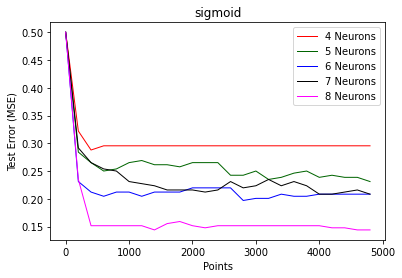

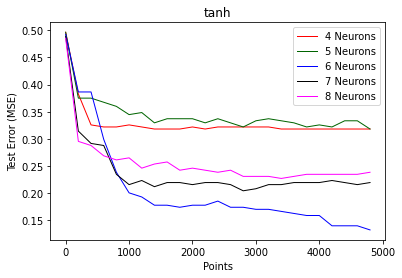

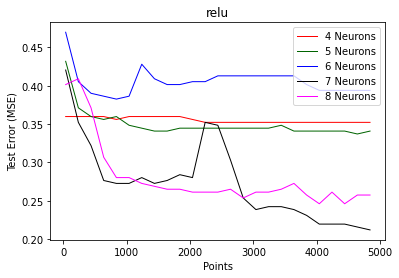

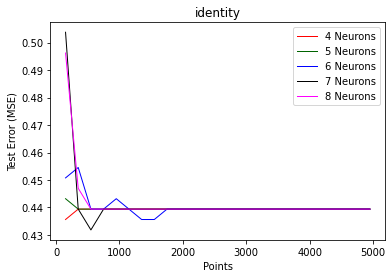

In [24]:
neurons = [4,5,6,7,8]
points = np.arange(iterations)
colors = ['r','darkgreen','b','k','fuchsia']
stepSize = 200
for i in range(len(activations)):
    for k in range(len(neurons)):
        if activations[i]=="relu":
            plt.plot(points[40::stepSize],arrays[i][k][40::stepSize],color=colors[k],label= "{0} Neurons".format(neurons[k]),linewidth=1,markevery=1)
        elif activations[i]=="identity":
            plt.plot(points[150::stepSize],arrays[i][k][150::stepSize],color=colors[k],label= "{0} Neurons".format(neurons[k]),linewidth=1,markevery=1)

        else:
            plt.plot(points[::stepSize],arrays[i][k][::stepSize],color=colors[k],label= "{0} Neurons".format(neurons[k]),linewidth=1,markevery=1)

    plt.title(activations[i])
    plt.legend()
    plt.xlabel("Points")
    plt.ylabel("Test Error (MSE)")
    plt.show()
    

In [ ]:

neurons = [4,5,6,7,8]
plt.figure(figsize=(7,7))
plt.plot(neurons,arrays[1],color='r',label="tanh")
plt.plot(neurons,arrays[0],color='g',label="sigmoid")
#plt.plot(neurons,arrays[2],color='c',label="relu")
#plt.plot(neurons,arrays[3],color='b',label="Identity")
plt.xlabel("Neurons")
plt.ylabel("Test error: MSE")
plt.legend()
plt.show()
print("hello")

In [127]:
'''
Using the brute force method figure out the optimal functions

then use the same functions in PSO and compare it with base line

'''

'\nUsing the brute force method figure out the optimal functions\n\nthen use the same functions in PSO and compare it with base line\n\n'

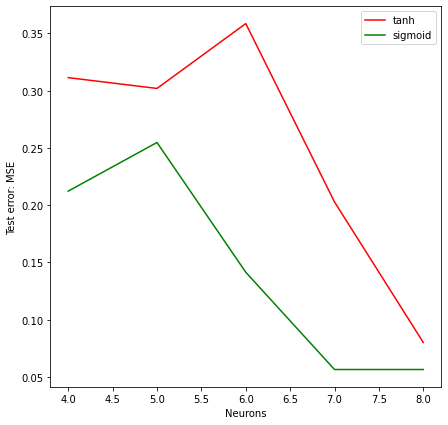

hello


In [129]:
import matplotlib.pyplot as plt

neurons = [4,5,6,7,8]
plt.figure(figsize=(7,7))
plt.plot(neurons,arrays[1],color='r',label="tanh")
plt.plot(neurons,arrays[0],color='g',label="sigmoid")
#plt.plot(neurons,arrays[2],color='c',label="relu")
#plt.plot(neurons,arrays[3],color='b',label="Identity")
plt.xlabel("Neurons")
plt.ylabel("Test error: MSE")
plt.legend()
plt.show()
print("hello")

In [35]:
np.random.seed(2)


2
